# Intelligent Systems Seminar Assignment 1

In [63]:
import statistics
import math
import random
from matplotlib import pyplot as plt
import numpy as np

## Population generation

Agent is an arithmetic expression constructed of numbers and symbols specified below.

Each number can be used `max_number_use` times, therefore the expression can contain from `1` to `len(numbers)*max_number_use` numbers.

After each number there is a symbol from `symbols`. But the symbol after the last number is ignored, but may be in future generations like an unexpressed gene in human genome. That decision was made primarly to make permutation like crossover easier to implement.

In [2]:
numbers = ['10', '25', '100', '5', '3']
symbols = ['+', '-', '*', '/']

max_number_use = 1
min_numbers_in_expresion = 1

target_value = 2512

In [3]:
def generate_agent():
    n_numbers = random.randint(min_numbers_in_expresion, len(numbers)*max_number_use)
    selected_numbers = random.sample(numbers*max_number_use, n_numbers)
    return [(number, random.choice(symbols)) for number in selected_numbers]

def agent_to_expression(agent):
        expression = "".join(n + s for i, (n, s) in enumerate(agent))
        return expression[:-1] # remove last operator
    
def evaluate_agent(agent):
    expression = agent_to_expression(agent)
    if len(expression) == 0: return 0
    else: return eval(expression)

def agent_to_string(agent):
    return f"{agent_to_expression(agent)} = {evaluate_agent(agent):.2f}"


Here are some randomly generated agents:

In [4]:
for i in range(20):
    a = generate_agent()
    print(agent_to_string(a))

10/5-3-25-100 = -126.00
100+25 = 125.00
10*3/25+5*100 = 501.20
25-3 = 22.00
10-3 = 7.00
100 = 100.00
5*25-10 = 115.00
10-5 = 5.00
10/5*100 = 200.00
5/100*3*25 = 3.75
100/5-3/25 = 19.88
10/3*100+5+25 = 363.33
10+3*100 = 310.00
5-10 = -5.00
25-100+5-3-10 = -83.00
3-100/10-25 = -32.00
100+25+3 = 128.00
25/100*10 = 2.50
3+100 = 103.00
100-25/10/5-3 = 96.50


## fitness

In [5]:
def fitness_abs(agent):
    return -abs(evaluate_agent(agent) - target_value)

In [40]:
def fitness_inverse(agent):
    return 1/(abs(evaluate_agent(agent) - target_value)+.0001) # + 0.0001 to avoid zero devision

In [7]:
def fitness_squared(agent):
    return -(evaluate_agent(agent) - target_value)**2

## Mutation

We defined 4 different types of mutation. Implementation and example mutations can be seen below:

In [8]:
agent = generate_agent()
print(agent)

[('10', '/')]


In [9]:
def mutation_change_symbol(agent):
    a = agent.copy()
    i = random.randrange(len(a))
    number, _ = a[i]
    a[i] = (number, random.choice(symbols))
    
    return a

In [10]:
print(agent)
print(mutation_change_symbol(agent))

[('10', '/')]
[('10', '-')]


In [11]:
def mutation_change_number(agent):
    a = agent.copy()
    agent_numbers = [number for number, _ in a]
    # choose numbers that can be added without violating `max_number_use`
    candidate_numbers = list(filter(lambda n: agent_numbers.count(n) < max_number_use, numbers))
    if len(candidate_numbers) == 0: return a
    i = random.randrange(len(a))
    _, symbol = a[i]
    a[i] = (random.choice(candidate_numbers), symbol)
    
    return a

In [12]:
print(agent)
print(mutation_change_number(agent))

[('10', '/')]
[('5', '/')]


In [13]:
def mutation_add_element(agent):
    a = agent.copy()
    agent_numbers = [number for number, _ in a]
    # choose numbers that can be added without violating `max_number_use`
    candidate_numbers = list(filter(lambda n: agent_numbers.count(n) < max_number_use, numbers))
    if len(candidate_numbers) == 0: return a
    a.insert(random.randint(0, len(a)), (random.choice(candidate_numbers), random.choice(symbols)))
    
    return a

In [14]:
print(agent)
print(mutation_add_element(agent))

[('10', '/')]
[('10', '/'), ('5', '-')]


In [15]:
def mutation_remove_element(agent):
    a = agent.copy()
    if len(a) <= 1: return a # nothing to remove
    del a[random.randrange(len(a))]
    
    return a

In [16]:
print(agent)
print(mutation_remove_element(agent))

[('10', '/')]
[('10', '/')]


In [17]:
def mutation(agent):
    mutation_type = random.randint(1, 4)
    if mutation_type == 1:
        return mutation_change_symbol(agent)
    if mutation_type == 2:
        return mutation_change_number(agent)
    if mutation_type == 3:
        return mutation_add_element(agent)
    if mutation_type == 4:
        return mutation_remove_element(agent)

In [18]:
print(agent)
print(mutation(agent))

[('10', '/')]
[('3', '+'), ('10', '/')]


## Crossover

Crossover takes 2 parents: `parent1` and `parent2`:

In [19]:
parent1 = generate_agent()
parent2 = generate_agent()
print(agent_to_string(parent1))
print(agent_to_string(parent2))

100+3-5/10*25 = 90.50
100-10-3/5*25 = 75.00


It than selects a section that overlaps both parents and initializes `child1` to a section of `parent1` and `child2` to a section of `parent2`.

In [20]:
min_len = min(len(parent1), len(parent2))
selection_start = random.randrange(0, min_len)
selection_end = random.randrange(selection_start, min_len)

child1 = parent1[selection_start:selection_end]
child2 = parent2[selection_start:selection_end]

print(agent_to_string(child1))
print(agent_to_string(child2))

5/10 = 0.50
3/5 = 0.60


The rest of the elements come from the other parent by removing the numbers that already come from the first parent.

In [21]:
def agent_substract(agent1, agent2):
    agent2_numbers = [n for n, _ in agent2]
    res = []
    for number, symbol in agent1:
        if number in agent2_numbers: agent2_numbers.remove(number)
        else: res.append((number, symbol))
    return res

In [22]:
parent1_remainder = agent_substract(parent1, child2)
parent2_remainder = agent_substract(parent2, child1)

print(agent_to_string(parent1_remainder))
print(agent_to_string(parent2_remainder))

100+10*25 = 350.00
100-3/25 = 99.88


In [23]:
child1.extend(parent2_remainder)
child2.extend(parent1_remainder)

print(agent_to_string(child1))
print(agent_to_string(child2))

5/10*100-3/25 = 49.88
3/5*100+10*25 = 310.00


Everything from above packed into a function:

In [24]:
def crossover(parent1, parent2):
    min_len = min(len(parent1), len(parent2))
    selection_start = random.randrange(0, min_len)
    selection_end = random.randrange(selection_start, min_len)

    child1 = parent1[selection_start:selection_end]
    child2 = parent2[selection_start:selection_end]
    child1.extend(agent_substract(parent2, child1))
    child2.extend(agent_substract(parent1, child2))
    
    return (child1, child2)

In [25]:
child1, child2 = crossover(parent1, parent2)
print(f"Parent 1: {agent_to_string(parent1)}; lenght: {len(parent1)}")
print(f"Parent 2: {agent_to_string(parent2)}; length: {len(parent2)}")
print(f"Child 1: {agent_to_string(child1)}; length: {len(child2)}")
print(f"Child 2: {agent_to_string(child2)}; length: {len(child2)}")

Parent 1: 100+3-5/10*25 = 90.50; lenght: 5
Parent 2: 100-10-3/5*25 = 75.00; length: 5
Child 1: 3-5/100-10-25 = -32.05; length: 5
Child 2: 10-3/100+5/25 = 10.17; length: 5


## Selection

In [27]:
def select_best_agents(population_with_fitness, n_agents):
    return list(sorted(population_with_fitness, key=lambda e: e[1], reverse=True))[:n_agents]

In [101]:
population_size = 100
max_iterations = 300

In [93]:
def evolve(
    population, fitness_function, selection_function, crossover_function, mutation_function, 
    mutation_probability=0.4, survival_probability=0.1, max_iterations=100, fitness_threshold=0, keep_best = False,
    verbose=False, plot=False
):
    population_size = len(population)
    
    min_fitness_log = []
    max_fitness_log = []
    mean_fitness_log = []
    
    iterations = 0
    
    for generation in range(max_iterations):
        iterations += 1
        # evaluate population
        population_with_fitness = [(a, fitness_function(a)) for a in population]
        population_fitness = [f for a, f in population_with_fitness]
        
        
        mean_fitness = statistics.mean(population_fitness)
        max_fitness = max(population_fitness)
        min_fitness = min(population_fitness)
        mean_fitness_log.append(mean_fitness)
        max_fitness_log.append(max_fitness)
        min_fitness_log.append(min_fitness)
        
        best_agents_with_fitness = selection_function(population_with_fitness, math.ceil(population_size*survival_probability))
        best_agents = [a for a, _ in best_agents_with_fitness]
        
        # print metrics
        if verbose:
            print(f"Generation {generation}: fitness min: {min_fitness:.2f}, max: {max_fitness:.2f}, mean: {mean_fitness:.2f}; best agent: {agent_to_string(best_agents[0])}")
            
        if max_fitness >= fitness_threshold: break
        
            
        if keep_best:
            population = best_agents.copy()
        else:
            population = []

        # crossover
        for i in range(len(population), population_size, 2):
            parent1, parent2 = random.sample(best_agents, 2)
            child1, child2 = crossover_function(parent1, parent2)
            population.append(child1)
            population.append(child2)
            
        # mutation
        for i, agent in enumerate(population):
            if random.random() < mutation_probability:
                population[i] = mutation_function(agent)
                
            
    if plot:
        plt.figure(figsize=(10,10))
        plt.plot(max_fitness_log, label="max")
        plt.plot(mean_fitness_log, label="mean")
        #plt.plot(min_fitness_log, label="min")
        plt.legend()
        
    return (iterations, (max_fitness_log, mean_fitness_log, min_fitness_log))

## Evaluation

Generation 0: fitness min: 0.00, max: 0.33, mean: 0.00; best agent: 10+5+100*25 = 2515.00
Generation 1: fitness min: 0.00, max: 0.33, mean: 0.01; best agent: 10+5+100*25 = 2515.00
Generation 2: fitness min: 0.00, max: 1.00, mean: 0.05; best agent: 10+3+100*25 = 2513.00
Generation 3: fitness min: 0.00, max: 10000.00, mean: 100.18; best agent: 10+100*25+5-3 = 2512.00


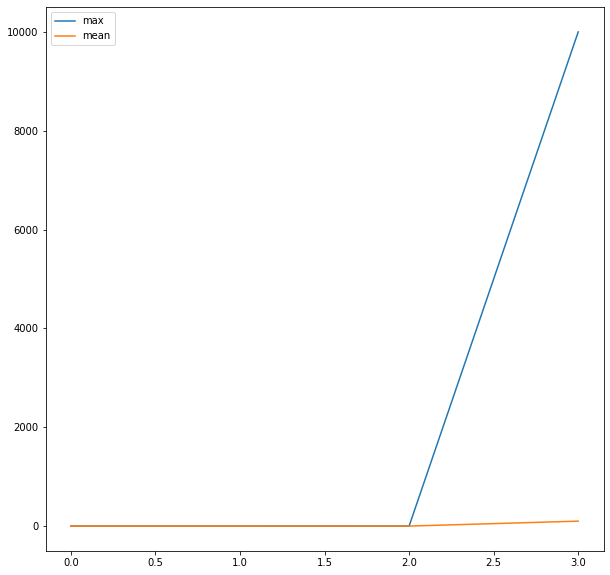

In [94]:
population = [generate_agent() for _ in range(population_size)]
_ = evolve(
    population,
    fitness_inverse,
    select_best_agents,
    crossover,
    mutation,
    fitness_threshold=10000.00,
    mutation_probability=0.2, survival_probability=0.2, max_iterations=300,
    verbose=True, keep_best=False, plot=True
)

### Comparison with random search

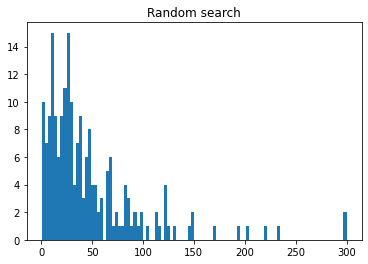

In [103]:
N = 200
iterations_log = []
for i in range(N):
    iterations = 0
    for i in range(max_iterations):
        iterations += 1
        population = [generate_agent() for _ in range(population_size)]
        population_with_fitness = [(a, fitness_abs(a)) for a in population]
        population_fitness = [f for a, f in population_with_fitness]
        if max(population_fitness) == 0: break

    iterations_log.append(iterations)

plt.title("Random search")
_ = plt.hist(iterations_log, bins=100)

### Different fitness functions

Lets see how does the choice of a fitness function effect performance. We run genetic alghorithm with each fitness function a 200 times and plot a histogram of iterations it took to find the optimal agent. 

abs - mean: 31.39, min: 1, max: 300, stdev: 76.96718546361791
inverse - mean: 22.895, min: 1, max: 300, stdev: 60.67148523485325
sqared - mean: 25.8, min: 1, max: 300, stdev: 66.69151965557427


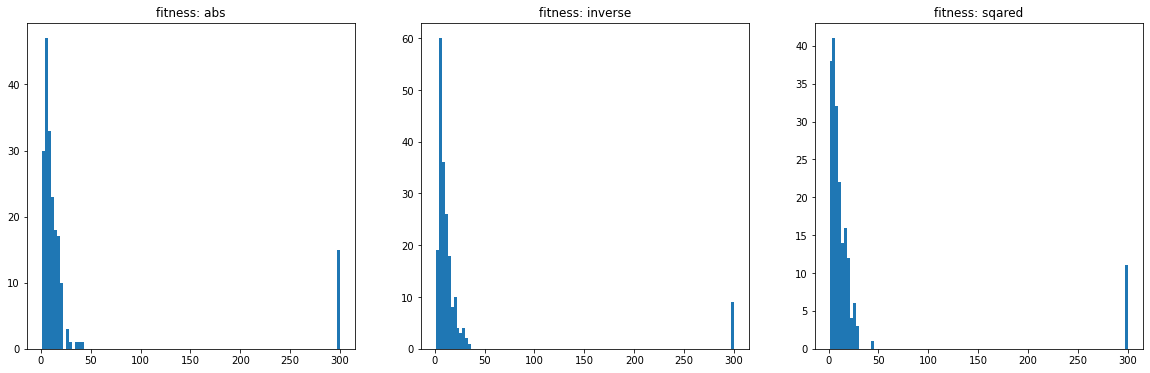

In [91]:
N = 200
fitness_functions = [(fitness_abs, 0, "abs"), (fitness_inverse, 10000, "inverse"), (fitness_squared, 0, "sqared")]

plt.figure(figsize=(20,6))

for j, (fitness_function, fitness_threshold, label) in enumerate(fitness_functions):
    iterations_log = []

    for i in range(N):
        population = [generate_agent() for _ in range(population_size)]
        iterations, _ = evolve(
            population,
            fitness_function,
            select_best_agents,
            crossover,
            mutation,
            mutation_probability=0.2, survival_probability=0.2, max_iterations=300, keep_best=False, fitness_threshold=fitness_threshold
        )

        iterations_log.append(iterations)
        
    print(f"{label} - mean: {statistics.mean(iterations_log)}, min: {min(iterations_log)}, max: {max(iterations_log)}, stdev: {statistics.stdev(iterations_log)}")
    
    plt.subplot(1, 3, j+1)
    plt.title(f"fitness: {label}")
    _ = plt.hist(iterations_log, bins=100)
        